Cell 1: Imports

In [6]:
import xml.etree.ElementTree as ET
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from torchvision.ops import box_iou

# Define dataset path
DATA_PATH = '/dtu/datasets1/02516/potholes'
IMG_FOLDER = os.path.join(DATA_PATH, 'images')
ANNOT_FOLDER = os.path.join(DATA_PATH, 'annotations')

# Parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256

Cell 2: Create train/test splits

In [7]:
# 1. Get all image filenames
all_images = sorted([f for f in os.listdir(IMG_FOLDER) if f.endswith('.png')])
print(f"Total images found: {len(all_images)}")

# 2. Shuffle and Split (80% Train, 20% Test)
random.seed(42) # Fixed seed for reproducibility
random.shuffle(all_images)

split_idx = int(0.8 * len(all_images))
train_images = all_images[:split_idx]
test_images = all_images[split_idx:]

print(f"Training set: {len(train_images)} images")
print(f"Test set: {len(test_images)} images")

Total images found: 665
Training set: 532 images
Test set: 133 images


Cell 3: Helper functions

In [8]:
def parse_annotation(xml_file):
    """Parses XML and returns normalized Ground Truth boxes (xmin, ymin, xmax, ymax)"""
    tree = ET.parse(xml_file)
    root = tree.getroot()
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    boxes = []
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text) / width
        ymin = int(bbox.find('ymin').text) / height
        xmax = int(bbox.find('xmax').text) / width
        ymax = int(bbox.find('ymax').text) / height
        boxes.append([xmin, ymin, xmax, ymax])
    
    # Handle images with no potholes (empty boxes)
    if len(boxes) == 0:
        return torch.empty((0, 4), dtype=torch.float32)
        
    return torch.tensor(boxes, dtype=torch.float32)

def get_selective_search_boxes(img, target_w=256, target_h=256):
    """Runs Selective Search and returns normalized Proposal boxes"""
    # Resize image for speed
    resized_img = cv2.resize(img, (target_w, target_h))
    
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(resized_img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process() # returns x, y, w, h
    
    proposals = []
    for (x, y, w, h) in rects:
        # Normalize directly using the resized dimensions
        xmin = x / target_w
        ymin = y / target_h
        xmax = (x + w) / target_w
        ymax = (y + h) / target_h
        proposals.append([xmin, ymin, xmax, ymax])
        
    return torch.tensor(proposals, dtype=torch.float32)

def calculate_recall(gt_boxes, proposal_boxes, top_k=[100, 500, 1000, 2000], iou_thresh=0.5):
    """Calculates recall for specific top-k thresholds on a SINGLE image"""
    results = {}
    
    total_gt = gt_boxes.shape[0]
    if total_gt == 0: 
        return {k: 1.0 for k in top_k} # If no pothole exists, recall is trivially 1.0 (or undefined, but usually ignored)

    # Pre-calculate IoUs for all proposals
    ious = box_iou(gt_boxes, proposal_boxes) 

    for k in top_k:
        # Safety check if we have fewer proposals than k
        k_limit = min(k, ious.shape[1])
        
        # Take only the top K proposals
        current_ious = ious[:, :k_limit]
        
        # For each GT box, did we find a proposal with IoU >= 0.5?
        if current_ious.shape[1] > 0:
            max_ious, _ = current_ious.max(dim=1) 
            found_count = (max_ious >= iou_thresh).sum().item()
        else:
            found_count = 0
            
        results[k] = found_count / total_gt
        
    return results

Cell 4: Sanity check

Visualizing: potholes10.png


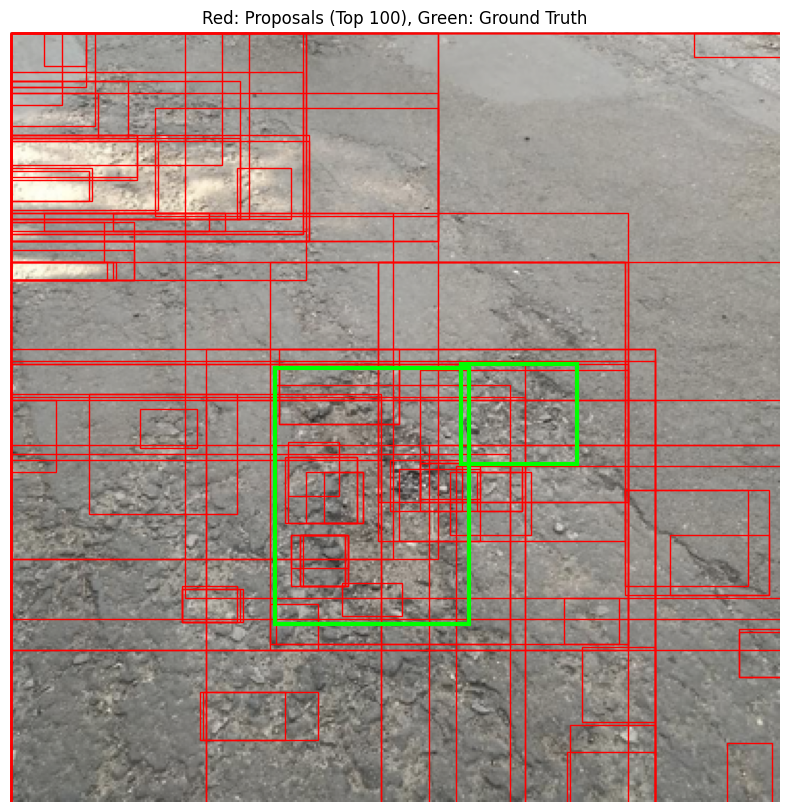

Recall for this image: {100: 0.5, 500: 0.5, 1000: 0.5, 2000: 0.5}


In [9]:
# Pick a random image from the training set
sample_name = train_images[0] 
print(f"Visualizing: {sample_name}")

img_path = os.path.join(IMG_FOLDER, sample_name)
xml_path = os.path.join(ANNOT_FOLDER, os.path.splitext(sample_name)[0] + '.xml')

# Load
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ss_boxes = get_selective_search_boxes(img)
gt_boxes = parse_annotation(xml_path)

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(img)
ax = plt.gca()

# Draw first 100 Proposals (Red)
for i in range(min(100, len(ss_boxes))):
    xmin, ymin, xmax, ymax = ss_boxes[i] # Corrected Unpacking
    width = (xmax - xmin) * img.shape[1]
    height = (ymax - ymin) * img.shape[0]
    rect = plt.Rectangle((xmin * img.shape[1], ymin * img.shape[0]), 
                         width, height, fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)

# Draw Ground Truth (Green, Thicker)
for i in range(len(gt_boxes)):
    xmin, ymin, xmax, ymax = gt_boxes[i]
    width = (xmax - xmin) * img.shape[1]
    height = (ymax - ymin) * img.shape[0]
    rect = plt.Rectangle((xmin * img.shape[1], ymin * img.shape[0]), 
                         width, height, fill=False, edgecolor='lime', linewidth=3)
    ax.add_patch(rect)

plt.title(f"Red: Proposals (Top 100), Green: Ground Truth")
plt.axis('off')
plt.show()

# Check stats for this image
print("Recall for this image:", calculate_recall(gt_boxes, ss_boxes))

Cell 5: Main loop

In [ ]:
# Accumulators for the average
proposal_counts = [100, 500, 1000, 2000]
total_recalls = {k: 0.0 for k in proposal_counts}
num_images = len(train_images)

print("Starting evaluation loop...")

for i, filename in enumerate(train_images):
    # 1. Paths
    img_name = filename if filename.endswith('.png') else filename + '.png'
    xml_name = os.path.splitext(img_name)[0] + '.xml'
    
    img_path = os.path.join(DATA_PATH, 'images', img_name)
    xml_path = os.path.join(DATA_PATH, 'annotations', xml_name)
    
    # 2. Load Data
    if not os.path.exists(img_path) or not os.path.exists(xml_path):
        print(f"Skipping missing file: {img_name}")
        num_images -= 1
        continue
        
    img = cv2.imread(img_path) # OpenCV loads as BGR
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
    gt_boxes = parse_annotation(xml_path)
    
    # 3. Run Selective Search
    ss_boxes = get_selective_search_boxes(img)
    
    # 4. Evaluate
    recalls = calculate_recall(gt_boxes, ss_boxes, top_k=proposal_counts)
    
    # 5. Accumulate results
    for k in proposal_counts:
        total_recalls[k] += recalls[k]
        
    # Optional: Print progress every 20 images
    if (i + 1) % 20 == 0:
        print(f"Processed {i + 1}/{len(train_images)} images...")

# Calculate Averages
avg_results = {k: total_recalls[k] / num_images for k in proposal_counts}

print("\n=== FINAL AVERAGE RECALL ===")
for k in proposal_counts:
    print(f"Top {k} Proposals: {avg_results[k]:.4f}")

Starting evaluation loop...
Processed 20/532 images...
Processed 40/532 images...
Processed 60/532 images...
Processed 80/532 images...
Processed 100/532 images...
Processed 120/532 images...
Processed 140/532 images...
Processed 160/532 images...
Processed 180/532 images...
Processed 200/532 images...
Processed 220/532 images...
Processed 240/532 images...
Processed 260/532 images...
Processed 280/532 images...
Processed 300/532 images...
Processed 320/532 images...
Processed 340/532 images...
Processed 360/532 images...
Processed 380/532 images...
Processed 400/532 images...
Processed 420/532 images...
Processed 440/532 images...
Processed 460/532 images...
Processed 480/532 images...
Processed 500/532 images...
Processed 520/532 images...

=== FINAL AVERAGE RECALL ===
Top 100 Proposals: 0.6891
Top 500 Proposals: 0.8302
Top 1000 Proposals: 0.8316
Top 2000 Proposals: 0.8316


Cell 6: Visualize

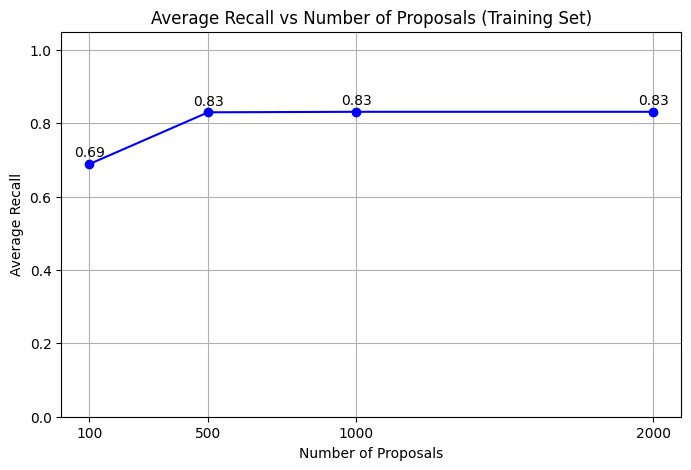

In [11]:
plt.figure(figsize=(8, 5))
x_vals = list(avg_results.keys())
y_vals = list(avg_results.values())

plt.plot(x_vals, y_vals, marker='o', linestyle='-', color='b')
plt.title('Average Recall vs Number of Proposals (Training Set)')
plt.xlabel('Number of Proposals')
plt.ylabel('Average Recall')
plt.grid(True)
plt.ylim(0, 1.05)
plt.xticks(proposal_counts)
for i, v in enumerate(y_vals):
    plt.text(x_vals[i], v + 0.02, f"{v:.2f}", ha='center')
plt.show()

Cell 7: Generate dataset

In [12]:
# Configuration
MAX_PROPOSALS = 500  # Based on your graph analysis
IOU_THRESHOLD = 0.5  # Standard threshold for positive/negative

train_data = []      # Will store dictionaries: {'img_path': str, 'box': list, 'label': int}
counts = {0: 0, 1: 0} # To check class imbalance

print(f"Generating training data with Top-{MAX_PROPOSALS} proposals...")

for i, filename in enumerate(train_images):
    # 1. Load Data
    xml_name = os.path.splitext(filename)[0] + '.xml'
    img_path = os.path.join(IMG_FOLDER, filename)
    xml_path = os.path.join(ANNOT_FOLDER, xml_name)
    
    if not os.path.exists(xml_path): continue
        
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 2. Get Ground Truth & Proposals
    gt_boxes = parse_annotation(xml_path) # Shape: [N_gt, 4]
    if len(gt_boxes) == 0: continue # Skip images with no potholes
        
    ss_boxes = get_selective_search_boxes(img) # Shape: [N_prop, 4]
    
    # 3. Limit to Top-N Proposals
    # ss_boxes are usually returned in order of 'score', so we just take the first N
    proposals = ss_boxes[:MAX_PROPOSALS]
    
    # 4. Calculate IoU for labeling
    # Matrix of shape [N_gt, N_proposals]
    ious = box_iou(gt_boxes, proposals)
    
    # For each proposal, find the BEST overlap with any GT box
    # max(dim=0) returns (values, indices) for each column (proposal)
    best_ious, _ = ious.max(dim=0)
    
    # 5. Create Samples
    for idx in range(len(proposals)):
        box = proposals[idx].tolist() # [xmin, ymin, xmax, ymax]
        iou_val = best_ious[idx].item()
        
        # Assign Label
        if iou_val >= IOU_THRESHOLD:
            label = 1 # Pothole
        else:
            label = 0 # Background
            
        train_data.append({
            'img_path': img_path,
            'box': box,
            'label': label,
            'iou': iou_val # Optional, helpful for debugging later
        })
        counts[label] += 1

    if (i+1) % 50 == 0:
        print(f"Processed {i+1} images...")

print("\n=== GENERATION COMPLETE ===")
print(f"Total Samples: {len(train_data)}")
print(f"Background (Class 0): {counts[0]}")
print(f"Potholes   (Class 1): {counts[1]}")
print(f"Pothole Ratio: {counts[1]/len(train_data):.2%}")

# Save the data for Project 4.2
torch.save(train_data, 'pothole_proposals_train.pt')
print("Saved to 'pothole_proposals_train.pt'")

Generating training data with Top-500 proposals...
Processed 50 images...
Processed 100 images...
Processed 150 images...
Processed 200 images...
Processed 250 images...
Processed 300 images...
Processed 350 images...
Processed 400 images...
Processed 450 images...
Processed 500 images...

=== GENERATION COMPLETE ===
Total Samples: 169593
Background (Class 0): 162344
Potholes   (Class 1): 7249
Pothole Ratio: 4.27%
Saved to 'pothole_proposals_train.pt'
